## PORTFOLIO INVESTMENT PROBLEM (PIP)

### Import Libraries

In [9]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import itertools
import yfinance as yf

import QUBO_module
import plotly.express as px

### DOWNLOAD COMPANIES

Link to the tickers website <br>
https://www.sec.gov/files/company_tickers.json

In [3]:
tickers = ['EQNR', 'ABT', 'AAPL', 'SLB', 'NFLX', 'UL', 'ETN', 'DIS', 'MUFG', 'EVLO', 'AXP', 'DE', 'V', 'PANW', 'AMAT', 'SHOP', 'SNY', 'NEE', 'PFE', 'CB', 'LLY', 'UNH', 'MRK', 'AMD', 'CVX', 'UNP', 'JPM', 'HDB', 'BA', 'SYK', 'T', 'AMZN', 'ADP', 'SONY', 'TSM', 'UBER', 'LRCX', 'BX', 'REGN', 'LIN', 'LVMUY', 'ISRG', 'ZTS', 'INTU', 'ORCL', 'AN', 'INTC', 'ITW', 'BSX', 'GILD', 'BRK-B', 'TMO', 'WFC', 'AMT', 'QCOM', 'MBGYY', 'PYPL', 'VRTX', 'SPGI', 'CSLLY', 'MDLZ', 'MDT', 'CSX', 'PLD', 'GOOG', 'IBM', 'CNI', 'HD', 'HCA', 'CMA', 'BMY', 'XOM', 'PM', 'NVDA', 'EQIX', 'META', 'COP', 'SO', 'VZ', 'TD', 'WMT', 'FI', 'NKE', 'JNJ', 'SBUX', 'CVS', 'MA', 'RTX', 'FMX', 'ASML', 'COST', 'AMGN', 'TMUS', 'TSLA', 'SPY', 'BUD', 'PBR', 'EBS', 'IBN', 'LTMAY', 'LOW', 'PBCRY', 'RY', 'RTNTF', 'HSBC', 'ABBV', 'TXN', 'PEP', 'QQQ', 'BRTX', 'MMC', 'MS', 'CHWY', 'TTE', 'BABA', 'EADSY', 'ACN', 'MO', 'BHP', 'SAP', 'LMT', 'CMCSA', 'MSFT', 'HON', 'CI', 'UPS']
print(len(tickers))

126


In [4]:
df_profit_matrix_companies = yf.download(['EQNR', 'ABT', 'AAPL', 'SLB', 'NFLX', 'UL', 'ETN', 'DIS', 'MUFG', 'EVLO', 'AXP', 'DE', 'V', 'PANW', 'AMAT', 'SHOP', 'SNY', 'NEE', 'PFE', 'CB', 'LLY', 'UNH', 'MRK', 'AMD', 'CVX', 'UNP', 'JPM', 'HDB', 'BA', 'SYK', 'T', 'AMZN', 'ADP', 'SONY', 'TSM', 'UBER', 'LRCX', 'BX', 'REGN', 'LIN', 'LVMUY', 'ISRG', 'ZTS', 'INTU', 'ORCL', 'AN', 'INTC', 'ITW', 'BSX', 'GILD', 'BRK-B', 'TMO', 'WFC', 'AMT', 'QCOM', 'MBGYY', 'PYPL', 'VRTX', 'SPGI', 'CSLLY', 'MDLZ', 'MDT', 'CSX', 'PLD', 'GOOG', 'IBM', 'CNI', 'HD', 'HCA', 'CMA', 'BMY', 'XOM', 'PM', 'NVDA', 'EQIX', 'META', 'COP', 'SO', 'VZ', 'TD', 'WMT', 'FI', 'NKE', 'JNJ', 'SBUX', 'CVS', 'MA', 'RTX', 'FMX', 'ASML', 'COST', 'AMGN', 'TMUS', 'TSLA', 'SPY', 'BUD', 'PBR', 'EBS', 'IBN', 'LTMAY', 'LOW', 'PBCRY', 'RY', 'RTNTF', 'HSBC', 'ABBV', 'TXN', 'PEP', 'QQQ', 'SAP', 'LMT', 'CMCSA', 'MSFT', 'HON', 'CI', 'UPS'], start = "2019-12-02", end = "2020-12-01")

[*********************100%***********************]  116 of 116 completed


### Data Preparation

In [5]:
# NORMALISATION DATA
df_profit_matrix_companies_norm = np.log(1 + df_profit_matrix_companies['Adj Close'].pct_change())
df_profit_matrix_companies_norm = df_profit_matrix_companies_norm[1:]

# Covariance matrix
covariance_matrix = np.array(df_profit_matrix_companies_norm.cov())
#Tickers of company
comp_tickers = list(df_profit_matrix_companies_norm.columns)
# Expectation value
exp_value = np.array(df_profit_matrix_companies_norm.mean())

### Function to make QUBO matrix

In [6]:
def QUBO_matrix(covariance_matrix, exp_value, P_companies, P_profit, e_0, accepted_number_companies):
    
    #1 Volatility
    #covariance_matrix = np.array(df_profit_matrix_companies_norm.cov())

    #2 Profitability
    #exp_value = np.array(df_profit_matrix_companies_norm.mean())
    exp_value_matrix = np.dot(np.transpose(np.array([exp_value])), np.array([exp_value]))

    #3 QUBO matrix
    QUBO_model = np.array([[covariance_matrix[i][j] + P_profit * (exp_value_matrix[i][j] - 2 * exp_value[i] * e_0) + P_companies * (1 - 2 * accepted_number_companies)  if i == j else covariance_matrix[i][j] + P_companies + P_profit * (exp_value_matrix[i][j]) for j in range(len(covariance_matrix))] for i in range(len(covariance_matrix))])

    return QUBO_model

### Set Parameters and Make QUBO matrix

In [10]:
months = len(df_profit_matrix_companies_norm)
number_companies = len(df_profit_matrix_companies_norm.columns)
size_matrix = number_companies
P_companies = 50
P_profit = 4000
e_0 = 0.006537834940166739
accepted_number_companies = 60

QUBO_model = QUBO_matrix(covariance_matrix, exp_value, P_companies, P_profit, e_0, accepted_number_companies)

# Matrix Representation
#print('QUBO MATRIX', pd.DataFrame(QUBO_model), sep="\n")

### Visualization of Profitability Companies

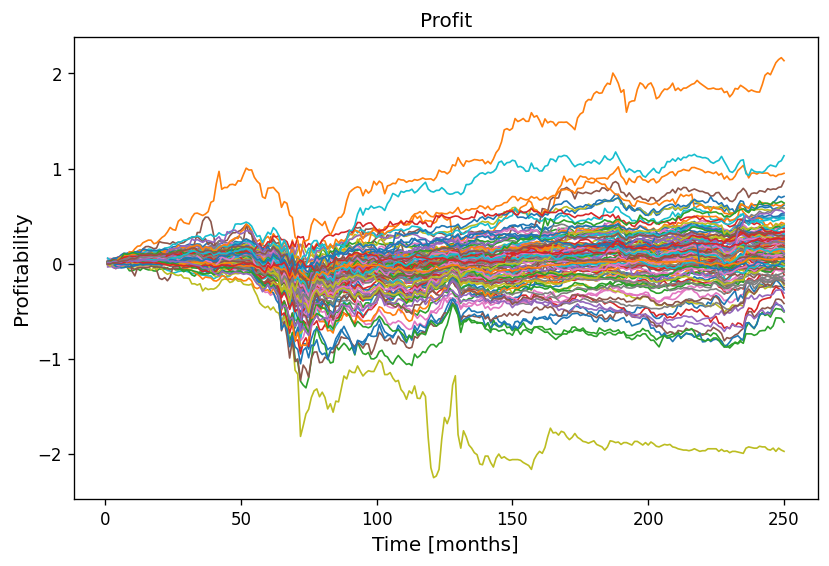

In [11]:
'''
# Visualization of Covariance Matrix
sns.heatmap(covariance_matrix, annot=True, fmt='g')
plt.show()
'''

fig, ax = plt.subplots(figsize=(8, 5), dpi = 120)
ax.set_title("Profit", fontsize = 12)
ax.set_ylabel("Profitability", fontsize = 12)
ax.set_xlabel("Time [months]", fontsize = 12)

time = np.arange(1, months, 1)
profit = []
for i in range(number_companies):
    a = []
    b = 0
    for j in range(1, months):
        b += df_profit_matrix_companies_norm.iloc[j, i]
        a.append(b)
    profit.append(a)

for i in range(number_companies):   
    ax.plot(time, profit[i], linewidth = 1, label='${i}$'.format(i=i))

plt.show()

### PIP SOLUTION

In [13]:
def solution(QUBO):
    x_vectors = np.array(list(itertools.product([0, 1], repeat = np.array(QUBO).shape[0])))
    b = np.inf
    for x_vector in x_vectors:
        y = np.dot(np.dot(x_vector, QUBO), x_vector.T)
        if y < b:
            b = y
            solution1 = x_vector
    return solution1

#print(QUBO_model)
print(solution(QUBO_model))

### SIMCIM SOLUTION

In [12]:
PIP_problem = QUBO_module.QUBO_optimizer()
print(PIP_problem.optimize(np.array(QUBO_model)))

c:\Users\79179\Desktop\шк\Skoltech\Industrial Immersion\Practice_codes\QUBO_module.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.J = torch.tensor(J, dtype=self.dtypef, device=self.device) / self.norm
c:\Users\79179\Desktop\шк\Skoltech\Industrial Immersion\Practice_codes\QUBO_module.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.b = torch.tensor(b, dtype=self.dtypef, device=self.device) / self.norm


[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0]


### FRONTIER BUILDER

In [15]:
def e_sum_solution(solution, comp_tickers, exp_value):
    dict1 = {}
    for i in range(len(comp_tickers)):
        dict1[comp_tickers[i]] = [solution[i], exp_value[i]]
    e_sum1 = 0
    for key in dict1:
        if dict1[key][0] == 1:
            e_sum1 += dict1[key][1]
    return e_sum1

def e_sum_max_comp(exp_value, accepted_number_companies):
    dict1 = {}
    max_values = 0
    exp_value = list(exp_value)
    for i in range(accepted_number_companies):
        max_values += exp_value.pop(exp_value.index(max(exp_value)))
    return(max_values)

In [16]:
def make_frontier_dict(exp_value, covariance_matrix, P_companies, accepted_number_companies, comp_tickers):
    step = e_sum_max_comp(exp_value, accepted_number_companies)/500
    lst_A = np.arange(-6, 6, 0.1, dtype=float)

    frontier_dict = {}
    for e_0 in np.arange(0, e_sum_max_comp(exp_value, accepted_number_companies), step):
        low = 0
        high = len(lst_A) - 1

        while low <= high:
            middle = (low + high) // 2
            A = 10 ** (lst_A[middle])
            
            QUBO_model = QUBO_matrix(covariance_matrix, exp_value, P_companies, A, e_0, accepted_number_companies)
            PIP_problem = QUBO_module.QUBO_optimizer()
            solution = PIP_problem.optimize(np.array(QUBO_model))

            if abs(e_0 - e_sum_solution(solution, comp_tickers, exp_value)) > step:
                low = middle + 1

            elif abs(e_0 - e_sum_solution(solution, comp_tickers, exp_value)) < step:
                high = middle - 1

        
        frontier_dict[e_sum_solution(solution, comp_tickers, exp_value)] = solution
    
    return frontier_dict

In [17]:
frontier_dict = make_frontier_dict(exp_value, covariance_matrix, P_companies, accepted_number_companies, comp_tickers)

c:\Users\79179\Desktop\шк\Skoltech\Industrial Immersion\Practice_codes\QUBO_module.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.J = torch.tensor(J, dtype=self.dtypef, device=self.device) / self.norm
c:\Users\79179\Desktop\шк\Skoltech\Industrial Immersion\Practice_codes\QUBO_module.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.b = torch.tensor(b, dtype=self.dtypef, device=self.device) / self.norm


In [20]:
def frontier_data(covariance_matrix, frontier_dict):
    b = []
    for key in frontier_dict:
        volatility = np.sqrt(np.dot(np.dot((np.array([frontier_dict[key]])), covariance_matrix), (np.array([frontier_dict[key]]).T)))
        optimum_sharp = key / volatility
        b.append([key, float(volatility), float(optimum_sharp)])
    b = pd.DataFrame(b)
    b.rename(columns = {0:'Return', 1: 'Volatility', 2: 'Optimum Sharp'}, inplace = True)
    return b
print(len(frontier_dict))

df_frontier_data = frontier_data(covariance_matrix, frontier_dict)
print(df_frontier_data)


262
       Return  Volatility  Optimum Sharp
0   -0.005245    1.379619      -0.003802
1   -0.002069    1.366002      -0.001515
2    0.002032    1.365468       0.001488
3    0.004739    1.342047       0.003531
4    0.002078    1.356671       0.001532
..        ...         ...            ...
257  0.076782    1.370270       0.056034
258  0.093072    1.361413       0.068364
259  0.084743    1.378768       0.061463
260  0.090674    1.252303       0.072406
261  0.092629    1.311070       0.070652

[262 rows x 3 columns]


### Frontier Visualization

In [21]:
fig = px.scatter(df_frontier_data, x = 'Volatility', y = 'Return', width=1200, height=800, color='Optimum Sharp', title='Efficient Frontier ' + '( Optimum sharp = ' + str(round(max(df_frontier_data['Optimum Sharp']), 5)) + ')')
fig.update_layout(margin=dict(l=40, r=40, t=40, b=20), paper_bgcolor="LightSteelBlue")
fig.show()

### Optimum Sharp Search

In [23]:
index_max_sharp = df_frontier_data.index[ df_frontier_data['Optimum Sharp'] == max(df_frontier_data['Optimum Sharp'])].tolist()
#data_optimum_sharp = [df_frontier_data['Return'][index_max_sharp[0]], df_frontier_data['Volatility'][index_max_sharp[0]]]
frontier_data_sharp = frontier_dict[df_frontier_data['Return'][index_max_sharp[0]]]

invested_comp = [comp_tickers[i] for i in range(len(frontier_data_sharp)) if frontier_data_sharp[i] == 1]
print(invested_comp)


['AAPL', 'ABBV', 'ABT', 'AMAT', 'AMD', 'AMZN', 'ASML', 'BMY', 'CMCSA', 'CNI', 'COST', 'CSX', 'DE', 'EBS', 'EQIX', 'ETN', 'GOOG', 'HD', 'HON', 'INTU', 'ISRG', 'ITW', 'JNJ', 'LIN', 'LLY', 'LOW', 'LRCX', 'LVMUY', 'MDLZ', 'META', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'PANW', 'PFE', 'PYPL', 'QCOM', 'QQQ', 'REGN', 'RTNTF', 'SHOP', 'SNY', 'SONY', 'SPGI', 'SPY', 'TMO', 'TMUS', 'TSLA', 'TSM', 'TXN', 'UBER', 'UL', 'UNH', 'UNP', 'UPS', 'VZ', 'WMT', 'ZTS']


### Expectation value of profit predicted by SIMCIM for the next month

In [24]:
df_profit_matrix_companies_predict = yf.download(['AAPL', 'ABBV', 'ABT', 'AMAT', 'AMD', 'AMZN', 'ASML', 'BMY', 'CMCSA', 'CNI', 'COST', 'CSX', 'DE', 'EBS', 'EQIX', 'ETN', 'GOOG', 'HD', 'HON', 'INTU', 'ISRG', 'ITW', 'JNJ', 'LIN', 'LLY', 'LOW', 'LRCX', 'LVMUY', 'MDLZ', 'META', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'PANW', 'PFE', 'PYPL', 'QCOM', 'QQQ', 'REGN', 'RTNTF', 'SHOP', 'SNY', 'SONY', 'SPGI', 'SPY', 'TMO', 'TMUS', 'TSLA', 'TSM', 'TXN', 'UBER', 'UL', 'UNH', 'UNP', 'UPS', 'VZ', 'WMT', 'ZTS'], start = '2020-12-02', end = '2021-01-01')

[*********************100%***********************]  60 of 60 completed


In [27]:
# NORMALISATION DATA PREDICTED
df_profit_matrix_companies_norm_predict = np.log(1 + df_profit_matrix_companies_predict['Adj Close'].pct_change())
df_profit_matrix_companies_norm_predict = df_profit_matrix_companies_norm_predict[1:]
# Expectation value
exp_value_predict = np.array(df_profit_matrix_companies_norm_predict.mean())
print(f'Expected profit {round(np.mean(exp_value_predict) * 100, 3)}%')

Expected profit 0.145%


### Expectation value of profit calculated by S&M for the next month

In [26]:
df_profit_matrix_companies_predict_SnM = yf.download(['EQNR', 'ABT', 'AAPL', 'SLB', 'NFLX', 'UL', 'ETN', 'DIS', 'MUFG', 'EVLO', 'AXP', 'DE', 'V', 'PANW', 'AMAT', 'SHOP', 'SNY', 'NEE', 'PFE', 'CB', 'LLY', 'UNH', 'MRK', 'AMD', 'CVX', 'UNP', 'JPM', 'HDB', 'BA', 'SYK', 'T', 'AMZN', 'ADP', 'SONY', 'TSM', 'UBER', 'LRCX', 'BX', 'REGN', 'LIN', 'LVMUY', 'ISRG', 'ZTS', 'INTU', 'ORCL', 'AN', 'INTC', 'ITW', 'BSX', 'GILD', 'BRK-B', 'TMO', 'WFC', 'AMT', 'QCOM', 'MBGYY', 'PYPL', 'VRTX', 'SPGI', 'CSLLY', 'MDLZ', 'MDT', 'CSX', 'PLD', 'GOOG', 'IBM', 'CNI', 'HD', 'HCA', 'CMA', 'BMY', 'XOM', 'PM', 'NVDA', 'EQIX', 'META', 'COP', 'SO', 'VZ', 'TD', 'WMT', 'FI', 'NKE', 'JNJ', 'SBUX', 'CVS', 'MA', 'RTX', 'FMX', 'ASML', 'COST', 'AMGN', 'TMUS', 'TSLA', 'SPY', 'BUD', 'PBR', 'EBS', 'IBN', 'LTMAY', 'LOW', 'PBCRY', 'RY', 'RTNTF', 'HSBC', 'ABBV', 'TXN', 'PEP', 'QQQ', 'SAP', 'LMT', 'CMCSA', 'MSFT', 'HON', 'CI', 'UPS'], start = '2020-12-02', end = '2021-01-01')

[*********************100%***********************]  116 of 116 completed


In [29]:
# NORMALISATION DATA PREDICTED by S&M
df_profit_matrix_companies_norm_predict_SnM = np.log(1 + df_profit_matrix_companies_predict_SnM['Adj Close'].pct_change())
df_profit_matrix_companies_norm_predict_SnM = df_profit_matrix_companies_norm_predict_SnM[1:]
# Expectation value
exp_value_predict_SnM = np.array(df_profit_matrix_companies_norm_predict_SnM.mean())
print(f'Expected profit {round(np.mean(exp_value_predict_SnM) * 100, 3)}%')

Expected profit 0.179%
